In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from random import *
from sklearn.metrics import confusion_matrix

#from keras.models import Model
#from keras.layers import Dense, Input, add, BatchNormalization, concatenate, Embedding, Flatten 
from tensorflow.keras.optimizers import Nadam
#from keras.layers.core import Dropout, Activation
#from keras.initializers import RandomNormal, Ones
from keras.models import load_model
from tensorflow.keras.models import Sequential, model_from_json

#import tensorflow as tf

import seaborn as sns

import random
from numpy import array
pd.options.mode.chained_assignment = None  # default='warn'

from os import listdir
from os.path import isfile, join

2023-05-06 17:18:25.928633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 17:18:26.080368: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-06 17:18:26.831905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native
2023-05-06 17:18:26.832206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Function PD: Calculate Poisson Deviance
def PD_function(pred, obs):
    PD = 200*( sum(pred) - sum(obs) + sum( np.log( (obs/pred)**(obs) ) ) )
    return PD/len(pred)

In [4]:

    
# evaluate a single mlp model
def evaluate_model(trainX, trainy, train_expo, trainbrand, trainregion,
                   activ_fonction_0, activ_fonction_1, activ_fonction_2,
                   nb_neurones_0, nb_neurones_1, nb_neurones_2, 
                   drop_out_1, drop_out_2
                  ):
    
    first_input = Input(shape=(7))
    
    brand_input = Input(shape=(1))
    region_input = Input(shape=(1))    
    
    
    Embedding_brand = Flatten()(Embedding(input_dim = 11, output_dim = 2)(brand_input))
    Embedding_region = Flatten()(Embedding(input_dim = 22, output_dim = 2)(region_input))
    
    merge_one_ = tf.keras.layers.Concatenate()([Embedding_brand, Embedding_region, first_input])
    
    first_dense_0 = Dense(nb_neurones_0+10)(merge_one_)
    act_dense_0 = Activation(activ_fonction_0)(first_dense_0)
    
    first_dense_0 = Dense(nb_neurones_0)(act_dense_0)
    act_dense_0 = Activation(activ_fonction_0)(first_dense_0)
    
    first_dense_1 = Dense(nb_neurones_1)(act_dense_0)
    act_dense_1 = Activation(activ_fonction_1)(first_dense_1)
    
    first_dense_2 = Dense(nb_neurones_2)(act_dense_1)
    act_dense_2 = Activation(activ_fonction_2)(first_dense_2)

    first_dense_3 = Dense(1, 
                          bias_initializer=tf.keras.initializers.Constant(value=-1.7942), 
                          #kernel_initializer=tf.keras.initializers.Ones()
                         )(act_dense_2)
    act_dense_3 = Activation('linear')(first_dense_3)

    second_input = Input(shape=(1, ))

    second_dense_1 = Dense(1, 
                           bias_initializer=tf.keras.initializers.Constant(value=-1.66), 
                           kernel_initializer=tf.keras.initializers.Constant(value=0.43), 
                           trainable=True)(add([act_dense_3, second_input])) 
    final_output = Activation('exponential')(second_dense_1) 

    model_ = Model(inputs=[first_input, second_input, brand_input, region_input], outputs=final_output)

    model_.compile(optimizer=Nadam(), loss='poisson')
    
    callback =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)
    
    history = model_.fit([trainX, train_expo, trainbrand, trainregion], trainy, epochs=500, 
                         verbose=0, validation_split=0.1, batch_size=8000, callbacks=[callback])

    #preds = model_.predict([testX, test_expo, testbrand, testregion]).flatten()  

    #plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    #plt.title('model loss')
    #plt.ylabel('loss')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
    #plt.show()

    model_.save("deep_learning_models/trained_"+str(randint(1, 1000000))+"_model.h5")
    
    return history, model_

In [5]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, X_test, expo_test, brand_test, region_test):
    
    # make predictions
    yhat = [model.predict([X_test, expo_test, brand_test, region_test], verbose=0) for model in members]
    yhats = array(yhat)
    
    result = np.mean(yhats, axis=0).flatten() 
    
    return result, yhats

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, testX, testy, testexpo, testbrand, testregion):
    # select a subset of members
    subset = members[:len(members)]
    
    # make prediction
    result, yhats = ensemble_predictions(subset, testX, testexpo, testbrand, testregion)
    
    # calculate accuracy 
    return PD_function(result, testy.flatten())

# evaluate a specific number of members in an ensemble
def evaluate_n_members_bis(members, testX, testexpo, testbrand, testregion):
    
    # select a subset of members
    subset = members[:len(members)]
    
    # make prediction
    result, yhats = ensemble_predictions(subset, testX, testexpo, testbrand, testregion)
    
    # calculate accuracy 
    return result, yhats


def Ensemble_fit(Xtrain_, ytrain_, expotrain_, brandtrain_, regiontrain_, 
                 samples=30, rate_OOB=0.2, type_ = "Bagging", ver_freq_train=True):
    
    n_splits = samples
    scores_, members_ = list(), list()
    
    for _ in range(n_splits):
        
        print(_)
        
        if type_ not in ["Pasting", "Bagging"]:
            raise ValueError('type_ needs to be numeric: "Pasting", "Bagging"')

        l = range(len(Xtrain_))
        
        if type_ == "Pasting":
            train_ix = random.sample(l, int(len(Xtrain_)*(1-rate_OOB)))
            test_ix = list(set(l) - set(train_ix))
        
        else: #"bagging"
            train_ix = np.random.choice(l, int(len(Xtrain_)*(1-rate_OOB)))
            test_ix = list(set(l) - set(np.unique(train_ix)))            
        
        # select data on n'utilise que les données de train 
        trainX, trainy, trainexpo, trainbrand, trainregion = Xtrain_[train_ix], ytrain_[train_ix], expotrain_[train_ix], brandtrain_[train_ix], regiontrain_[train_ix]  
        testX, testy, testexpo, testbrand, testregion = Xtrain_[test_ix], ytrain_[test_ix], expotrain_[test_ix], brandtrain_[test_ix], regiontrain_[test_ix]
    
        activ_fonction_0, activ_fonction_1, activ_fonction_2 = random.sample(["tanh"], 1), random.sample(["tanh"], 1), random.sample(["tanh"], 1)
        nb_neurones_0, nb_neurones_1, nb_neurones_2 = random.sample([30, 25, 20], 1), random.sample([20, 15, 10], 1), random.sample([15, 10, 5], 1)
        drop_out_1, drop_out_2 = random.sample([0.02, 0.04, 0.06, 0.08], 1), random.sample([0.02, 0.04, 0.06, 0.08], 1)
        
        print(activ_fonction_0[0], activ_fonction_1[0], activ_fonction_2[0], nb_neurones_0[0], nb_neurones_1[0], nb_neurones_2[0])
            
        # evaluate model
        model, model_fit = evaluate_model(trainX, trainy, trainexpo, trainbrand, trainregion,  
                                         activ_fonction_0[0], activ_fonction_1[0], activ_fonction_2[0], 
                                         nb_neurones_0[0], nb_neurones_1[0], nb_neurones_2[0], 
                                         drop_out_1[0], drop_out_2[0])
        

        #print('> OOB > %.3f' % test_acc)
        #scores_.append(test_acc)
        members_.append(model_fit)   
    
    return members_


def step_wise_bagging_strat_1(members__, validX, validy, validexpo, validbrand, validregion, init_score_dev=100, prop=0.1):

    save_result = pd.DataFrame(columns=['candidat','dev'])
        
    for c in members__:
                
        ensemble_score_test = evaluate_n_members([c], validX, validy, validexpo, validbrand, validregion)
            
        save_result = save_result.append({'candidat':c, 'dev':ensemble_score_test}, ignore_index=True)
        

    #trier les 
    save_model = []
    for _ in range(len(members__)):
        
        if len(save_model)==int(prop*len(members__)):
            
            print('breakkkkkkkkk')
    
            break
        
        else:
        
            index = save_result['dev'].idxmin()
            print("index", index)
            save_model.append(save_result['candidat'][index])

            save_result = save_result.drop([index], axis=0)
    
        if len(save_model)==int(prop*len(members__)):
            
            print('breakkkkkkkkk')
    
            break
        
    return save_model
     

def step_wise_bagging_strat_2(members__, validX, validy, validexpo, validbrand, validregion, init_score_dev=100):
    save_model = []
    candidat = members__
    
    
    score_dev = init_score_dev
    iteration=0
    
    while len(candidat)>0:
    
        #stacker les resultats
        save_result = pd.DataFrame(columns=['candidat','dev'])
        print("La deviance de référence est :", score_dev)
        #print('les variables candidates pour le modèle sont :', candidat)
        
        for c in candidat:
            iteration = iteration+1
    
            model = save_model + [c]
            ensemble_score_test = evaluate_n_members(model, validX, validy, validexpo, validbrand, validregion)
            save_result = save_result.append({'candidat':c, 'dev':ensemble_score_test}, ignore_index=True)
    
        index = save_result['dev'].idxmin()
    
        if score_dev<save_result['dev'][index]:
    
            print('breakkkkkkkkk')
    
            break
    
        else:
            score_dev=save_result['dev'][index]
    
        save_model.append(save_result['candidat'][index])
        candidat.remove(save_result['candidat'][index])                  

    return save_model

In [6]:

def construct_resultats(members, bagging_classic, df_poisson_20, df_poisson_30, df_poisson_40, strat_2, table_name,
                        X_train, log_exp_train, brand_train, region_train, 
                        X_valid, y_valid, log_exp_valid, brand_valid, region_valid, 
                        X_test, log_exp_test, brand_test, region_test):

############################### Bagging ##########################################################
    print('Bagging classic')
    
    predictions_test_bagg, yhats_test_bagg = evaluate_n_members_bis(members, X_test, log_exp_test, brand_test, region_test)
    predictions_train_bagg, yhats_train_bagg = evaluate_n_members_bis(members, X_train, log_exp_train, brand_train, region_train)
    
    #deviance
    table_modal= [np.round(PD_function(predictions_train_bagg, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_bagg, y_test.flatten()),6),
                  (sum(predictions_train_bagg) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_bagg) -sum(y_test.flatten()))/sum(y_test.flatten())*100]
    
    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    bagging_classic = bagging_classic.append(cnt, ignore_index=True)
    
    
    return bagging_classic, yhats_train_bagg, yhats_test_bagg


In [7]:
def construct_resultats_st_2(members, bagging_classic, df_poisson_20, df_poisson_30, df_poisson_40, strat_2, table_name,
                        X_train, log_exp_train, brand_train, region_train, 
                        X_valid, y_valid, log_exp_valid, brand_valid, region_valid, 
                        X_test, log_exp_test, brand_test, region_test, df_matrix_train_, df_matrix_valid_):

############################### Bagging ##########################################################
    print('strategie 2')
    
    subsample_model_strat_2 = step_wise_bagging_strat_2(members, X_valid, y_valid, 
                                                        log_exp_valid, brand_valid, 
                                                        region_valid, init_score_dev=1000)

    
    predictions_test_strat_2, yhats_test_bagg =  evaluate_n_members_bis(subsample_model_strat_2, X_test, log_exp_test, brand_test, region_test)
    predictions_train_strat_2, yhats_train_bagg = evaluate_n_members_bis(subsample_model_strat_2, X_train, log_exp_train, brand_train, region_train)
    
    #deviance
    table_modal= [np.round(PD_function(predictions_train_strat_2, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_strat_2, y_test.flatten()),6),
                  (sum(predictions_train_strat_2) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_strat_2) -sum(y_test.flatten()))/sum(y_test.flatten())*100]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    strat_2 = strat_2.append(cnt, ignore_index=True)    
    
    print(strat_2)
    
    cf_matrix_train = confusion_matrix(y_train['ClaimNb'], np.round(predictions_train).astype(int))
    
    if cf_matrix_train.shape[0] == 4:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[1]], axis=0)

    if cf_matrix_train.shape[1] == 2:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)
    if cf_matrix_train.shape[1] == 3:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)
    if cf_matrix_train.shape[1] == 4:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)
    
    df_matrix_train_ = df_matrix_train_ + cf_matrix_train
    
    cf_matrix_valid = confusion_matrix(y_valid['ClaimNb'], np.round(predictions_valid).astype(int))
    print(cf_matrix_valid)
    
    if cf_matrix_valid.shape[0] == 4:
        cf_matrix_valid = np.append(cf_matrix_valid, [[0]*cf_matrix_valid.shape[1]], axis=0)

    if cf_matrix_valid.shape[1] == 2:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)
    if cf_matrix_valid.shape[1] == 3:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)
    if cf_matrix_valid.shape[1] == 4:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)
    
    df_matrix_valid_ = df_matrix_valid_ + cf_matrix_valid
    
    return strat_2, yhats_train_bagg, yhats_test_bagg, df_matrix_train_, df_matrix_valid_

def construct_resultats_st_1(members, bagging_classic, df_poisson_20, df_poisson_30, df_poisson_40, strat_2, table_name,
                        X_train, log_exp_train, brand_train, region_train, 
                        X_valid, y_valid, log_exp_valid, brand_valid, region_valid, 
                        X_test, log_exp_test, brand_test, region_test):

############################### Bagging ##########################################################
    print('strategie 1')
    
    subsample_model_40 = step_wise_bagging_strat_1(members, X_valid, y_valid, 
                                                   log_exp_valid, brand_valid, 
                                                   region_valid, init_score_dev=100, prop=0.4)
            
    predictions_test_40, yhats_test_bagg_40 =  evaluate_n_members_bis(subsample_model_40, X_test, log_exp_test, brand_test, region_test)
    predictions_train_40, yhats_train_bagg_40 = evaluate_n_members_bis(subsample_model_40, X_train, log_exp_train, brand_train, region_train)
    
    #deviance
    table_modal= [np.round(PD_function(predictions_train_40, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_40, y_test.flatten()),6),
                  (sum(predictions_train_40) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_40) -sum(y_test.flatten()))/sum(y_test.flatten())*100]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    df_poisson_40 = df_poisson_40.append(cnt, ignore_index=True)
    
    print(df_poisson_40)
    
            
    predictions_test_20, yhats_test_bagg_20 =  evaluate_n_members_bis(subsample_model_40[0:int(len(members)*0.2)], X_test, log_exp_test, brand_test, region_test)
    predictions_train_20, yhats_train_bagg_20 = evaluate_n_members_bis(subsample_model_40[0:int(len(members)*0.2)], X_train, log_exp_train, brand_train, region_train)
    
    
    #deviance
    table_modal= [np.round(PD_function(predictions_train_20, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_20, y_test.flatten()),6),
                  (sum(predictions_train_20) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_20) -sum(y_test.flatten()))/sum(y_test.flatten())*100]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    df_poisson_20 = df_poisson_20.append(cnt, ignore_index=True)
    
          
    predictions_test_30, yhats_test_bagg_30 =  evaluate_n_members_bis(subsample_model_40[0:int(len(members)*0.3)], 
                                                  X_test, log_exp_test, brand_test, region_test)
    predictions_train_30, yhats_train_bagg_30 = evaluate_n_members_bis(subsample_model_40[0:int(len(members)*0.3)],
                                                  X_train, log_exp_train, brand_train, region_train)
    
    #deviance
    table_modal= [np.round(PD_function(predictions_train_30, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_30, y_test.flatten()),6),
                  (sum(predictions_train_30) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_30) -sum(y_test.flatten()))/sum(y_test.flatten())*100]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    df_poisson_30 = df_poisson_30.append(cnt, ignore_index=True)
    
    cf_matrix_train = confusion_matrix(y_train['ClaimNb'], np.round(predictions_train).astype(int))
    
    if cf_matrix_train.shape[0] == 4:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[1]], axis=0)

    if cf_matrix_train.shape[1] == 2:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)
    if cf_matrix_train.shape[1] == 3:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)
    if cf_matrix_train.shape[1] == 4:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)
    
    df_matrix_train_ = df_matrix_train_ + cf_matrix_train
    
    cf_matrix_valid = confusion_matrix(y_valid['ClaimNb'], np.round(predictions_valid).astype(int))
    print(cf_matrix_valid)
    
    if cf_matrix_valid.shape[0] == 4:
        cf_matrix_valid = np.append(cf_matrix_valid, [[0]*cf_matrix_valid.shape[1]], axis=0)

    if cf_matrix_valid.shape[1] == 2:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)
    if cf_matrix_valid.shape[1] == 3:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)
    if cf_matrix_valid.shape[1] == 4:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)
    
    df_matrix_valid_ = df_matrix_valid_ + cf_matrix_valid
    
    
    
    return df_poisson_40, yhats_train_bagg_40, yhats_test_bagg_40, df_poisson_30, yhats_train_bagg_30, yhats_test_bagg_30, df_poisson_20, yhats_train_bagg_20, yhats_test_bagg_20, df_matrix_train_, df_matrix_valid_ 

In [8]:
bagging_classic = pd.DataFrame()
df_poisson_10 = pd.DataFrame()
df_poisson_20 = pd.DataFrame()
df_poisson_30 = pd.DataFrame()
df_poisson_40 = pd.DataFrame()
strat_2 = pd.DataFrame()

df_matrix_train = 0
df_matrix_valid = 0

table_name = ["deviance_train", "deviance_test", "diff_train", "diff_test"]
members = []

ser = 87

for p in [ser]:
    
    print(p)
    
    data_learn = pd.read_csv("data_learn_62.csv")
    data_test = pd.read_csv("data_test_62.csv")
    
    nex_data = pd.concat([data_learn, data_test])
    
    data_learn_, data_test_ = train_test_split(nex_data, stratify=nex_data['ClaimNb'], test_size=0.1, random_state=p)
    
    data_learn_['Exposure'] = data_learn_['Exposure'].clip(upper=1)
    data_test_['Exposure'] = data_test_['Exposure'].clip(upper=1)
    
    data_learn_['Area'] = data_learn_['Area'].map({"A": 1, "B": 2,"C": 3,"D": 4,"E": 5,"F": 6,})
    data_test_['Area'] = data_test_['Area'].map({"A": 1, "B": 2,"C": 3,"D": 4,"E": 5,"F": 6,})
    
    data_learn_ = data_learn_.drop(["Area_class_1","Area_class_2","Area_class_3","Area_class_4",'ClaimAmount', 'DrivAge', 'BonusMalus',
                                    "VehBrand_class_1", "VehBrand_class_2", "VehBrand_class_3",
                                    'Density',"Region_class_1", "Region_class_2", "Region_class_3", "Region_class_4" , 
                                    'VehAge', 'VehGas', "VehGas_class_2"], axis=1)

    data_test_ = data_test_.drop(["Area_class_1","Area_class_2","Area_class_3","Area_class_4",'ClaimAmount', 'DrivAge', 'BonusMalus',
                                  "VehBrand_class_1", "VehBrand_class_2", "VehBrand_class_3",
                                  'Density',"Region_class_1", "Region_class_2", "Region_class_3", "Region_class_4" , 
                                  'VehAge', 'VehGas', "VehGas_class_2"], axis=1)
    
    # train test split 
    X_train__, X_valid__ = train_test_split(data_learn_, stratify=data_learn_['ClaimNb'], test_size=0.1, random_state=p)
    
    
    #################### label encoding
    
    le_region = preprocessing.LabelEncoder()
    le_region.fit(X_train__['Region'])

    le_brand = preprocessing.LabelEncoder()
    le_brand.fit(X_train__['VehBrand'])
    
    y_train = np.array(X_train__.filter(['ClaimNb']))
    log_exp_train= np.array(np.log(X_train__.filter(['Exposure'])))
    region_train = np.array(le_region.transform(X_train__['Region']))
    brand_train = np.array(le_brand.transform(X_train__['VehBrand']))
    x_train = X_train__.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])

    y_valid = np.array(X_valid__.filter(['ClaimNb']))
    log_exp_valid= np.array(np.log(X_valid__.filter(['Exposure'])))
    region_valid = np.array(le_region.transform(X_valid__['Region']))
    brand_valid = np.array(le_brand.transform(X_valid__['VehBrand']))
    x_valid = X_valid__.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])
    
    #valid
    y_test = np.array(data_test_.filter(['ClaimNb']))
    log_exp_test = np.array(np.log(data_test_.filter(['Exposure'])))
    region_test = np.array(le_region.transform(data_test_['Region']))
    brand_test = np.array(le_brand.transform(data_test_['VehBrand']))
    x_test = data_test_.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])
    
    #feature eng
    cs = MinMaxScaler()
    X_train = np.array(2*((x_train - x_train.min())/(x_train.max()-x_train.min())) - 1)
    X_valid = np.array(2*((x_valid - x_train.min())/(x_train.max()-x_train.min())) - 1)
    X_test = np.array(2*((x_test - x_train.min())/(x_train.max()-x_train.min())) - 1)
    
    #fit models
    #ms = 60
    #members = Ensemble_fit(X_train, y_train, log_exp_train, brand_train, region_train,
    #                               samples=ms, rate_OOB=0.1, type_ = "Bagging",
    #                               ver_freq_train=True)

    fichiers_h5 = [f for f in listdir("deep_learning_models/h5") if isfile(join("deep_learning_models/h5", f))]
    fichiers_json = [f for f in listdir("deep_learning_models/json") if isfile(join("deep_learning_models/json", f))]

    for i in range(0, len(fichiers_h5)):
        
        json_file = open("deep_learning_models/json/"+str(fichiers_json[i]), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights("deep_learning_models/h5/"+str(fichiers_h5[i]))
        print("Loaded model from disk")

        #model = load_model("deep_learning_models/"+str(fichiers[0]))
        loaded_model.compile(optimizer=Nadam(), loss='poisson')
        members.append(loaded_model)
    
    bagging_classic, y_hat_train_40, y_hat_test_40 = construct_resultats(members[0:20], bagging_classic, df_poisson_20, df_poisson_30, df_poisson_40, strat_2, table_name,
                                                                                                               X_train, log_exp_train, brand_train, region_train, 
                                                                                                               X_valid, y_valid, log_exp_valid, brand_valid, region_valid, 
                                                                                                               X_test, log_exp_test, brand_test, region_test)

    strat_2, yhats_train_bagg_s2_40, yhats_test_bagg_s2_40, df_matrix_train, df_matrix_valid = construct_resultats_st_2(members[0:20], bagging_classic, df_poisson_20, df_poisson_30, df_poisson_40, strat_2, table_name,
                                                                                                               X_train, log_exp_train, brand_train, region_train, 
                                                                                                               X_valid, y_valid, log_exp_valid, brand_valid, region_valid, 
                                                                                                               X_test, log_exp_test, brand_test, region_test, 
                                                                                     df_matrix_train, df_matrix_valid)
    
    #df_poisson_40, yhats_train_bagg_40_40, yhats_test_bagg_40_40, df_poisson_30, yhats_train_bagg_30_40, yhats_test_bagg_30_40, df_poisson_20, yhats_train_bagg_20_40, yhats_test_bagg_20_40 = construct_resultats_st_1(members[0:20], bagging_classic, df_poisson_20, df_poisson_30, df_poisson_40, strat_2, table_name,
    #                                                                                                           X_train, log_exp_train, brand_train, region_train, 
    #                                                                                                           X_valid, y_valid, log_exp_valid, brand_valid, region_valid, 
    #                                                                                                           X_test, log_exp_test, brand_test, region_test, 
    #                                                                                                           df_matrix_train, df_matrix_valid
   #                                                                                                            )

87


2023-05-06 17:18:36.011821: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-06 17:18:36.011858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jupyter-30-dafnis-2ekrasniqi-40allianz-2efr
2023-05-06 17:18:36.011863: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jupyter-30-dafnis-2ekrasniqi-40allianz-2efr
2023-05-06 17:18:36.012088: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.12
2023-05-06 17:18:36.012108: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.12
2023-05-06 17:18:36.012111: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.12
2023-05-06 17:18:36.012368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


KeyboardInterrupt: 

In [ ]:
df_poisson_20 

In [ ]:
df_poisson_30

In [ ]:
df_poisson_40

In [ ]:
bagging_classic

In [ ]:
strat_2

In [14]:
df = pd.concat([df_poisson_20 , df_poisson_30, df_poisson_40, bagging_classic, strat_2])
df.to_csv('resultats_20_'+str(ser)+'.csv', index=False)

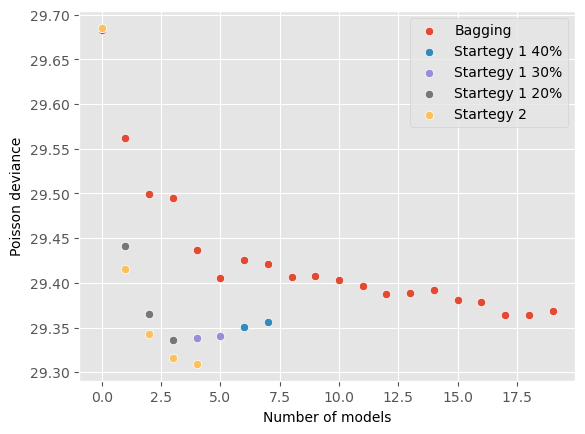

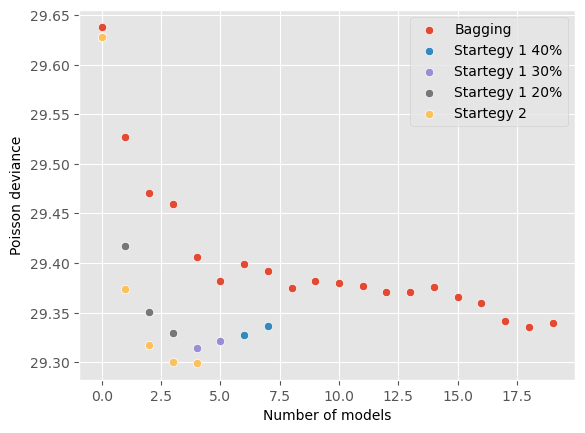

In [16]:
yhats_test_bagg = [np.round(PD_function(np.mean(y_hat_test_40[:i+1], axis=0).flatten(), y_test.flatten()),6) for i in range(20)]
sns.scatterplot(x=range(len(y_hat_test_40)), y=yhats_test_bagg, label='Bagging')

yhats_test_bagg = [np.round(PD_function(np.mean(yhats_test_bagg_40_40[:i+1], axis=0).flatten(), y_test.flatten()),6) for i in range(yhats_test_bagg_40_40.shape[0])]
sns.scatterplot(x=range(yhats_test_bagg_40_40.shape[0]), y=yhats_test_bagg, label='Startegy 1 40%')

yhats_test_bagg = [np.round(PD_function(np.mean(yhats_test_bagg_30_40[:i+1], axis=0).flatten(), y_test.flatten()),6) for i in range(yhats_test_bagg_30_40.shape[0])]
sns.scatterplot(x=range(yhats_test_bagg_30_40.shape[0]), y=yhats_test_bagg, label='Startegy 1 30%')

yhats_test_bagg = [np.round(PD_function(np.mean(yhats_test_bagg_20_40[:i+1], axis=0).flatten(), y_test.flatten()),6) for i in range(yhats_test_bagg_20_40.shape[0])]
sns.scatterplot(x=range(yhats_test_bagg_20_40.shape[0]), y=yhats_test_bagg, label='Startegy 1 20%')

yhats_test_bagg = [np.round(PD_function(np.mean(yhats_test_bagg_s2_40[:i+1], axis=0).flatten(), y_test.flatten()),6) for i in range(yhats_test_bagg_s2_40.shape[0])]
sns.scatterplot(x=range(yhats_test_bagg_s2_40.shape[0]), y=yhats_test_bagg, label='Startegy 2')

plt.xlabel('Number of models')
plt.ylabel('Poisson deviance')
plt.show()


yhats_train_bagg = [np.round(PD_function(np.mean(y_hat_train_40[:i+1], axis=0).flatten(), y_train.flatten()),6) for i in range(20)]
sns.scatterplot(x=range(len(y_hat_train_40)), y=yhats_train_bagg, label='Bagging')

yhats_train_bagg = [np.round(PD_function(np.mean(yhats_train_bagg_40_40[:i+1], axis=0).flatten(), y_train.flatten()),6) for i in range(yhats_train_bagg_40_40.shape[0])]
sns.scatterplot(x=range(yhats_train_bagg_40_40.shape[0]), y=yhats_train_bagg, label='Startegy 1 40%')

yhats_train_bagg = [np.round(PD_function(np.mean(yhats_train_bagg_30_40[:i+1], axis=0).flatten(), y_train.flatten()),6) for i in range(yhats_train_bagg_30_40.shape[0])]
sns.scatterplot(x=range(yhats_train_bagg_30_40.shape[0]), y=yhats_train_bagg, label='Startegy 1 30%')

yhats_train_bagg = [np.round(PD_function(np.mean(yhats_train_bagg_20_40[:i+1], axis=0).flatten(), y_train.flatten()),6) for i in range(yhats_train_bagg_20_40.shape[0])]
sns.scatterplot(x=range(yhats_train_bagg_20_40.shape[0]), y=yhats_train_bagg, label='Startegy 1 20%')

yhats_train_bagg = [np.round(PD_function(np.mean(yhats_train_bagg_s2_40[:i+1], axis=0).flatten(), y_train.flatten()),6) for i in range(yhats_train_bagg_s2_40.shape[0])]
sns.scatterplot(x=range(yhats_train_bagg_s2_40.shape[0]), y=yhats_train_bagg, label='Startegy 2')

plt.xlabel('Number of models')
plt.ylabel('Poisson deviance')
plt.show()

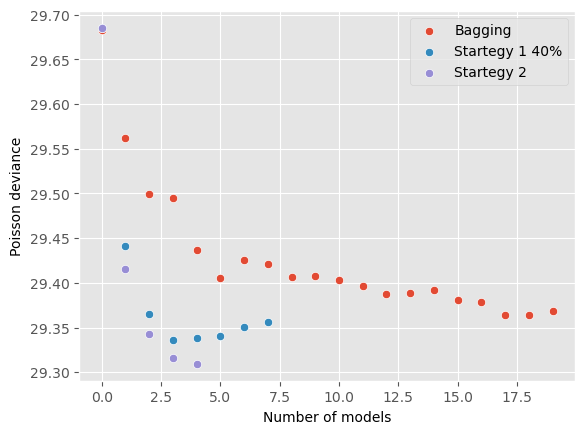

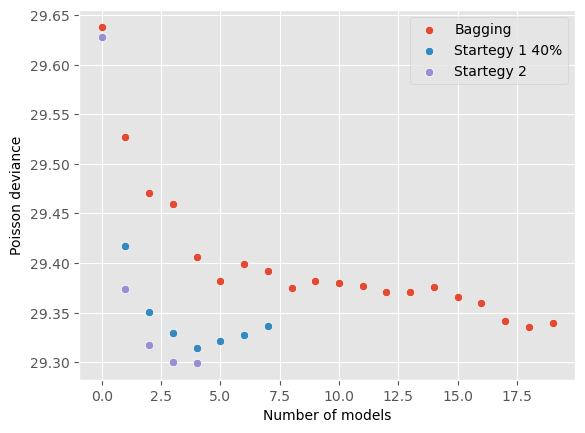

In [17]:
yhats_test_bagg = [np.round(PD_function(np.mean(y_hat_test_40[:i+1], axis=0).flatten(), y_test.flatten()),6) for i in range(20)]
sns.scatterplot(x=range(len(y_hat_test_40)), y=yhats_test_bagg, label='Bagging')

yhats_test_bagg = [np.round(PD_function(np.mean(yhats_test_bagg_40_40[:i+1], axis=0).flatten(), y_test.flatten()),6) for i in range(yhats_test_bagg_40_40.shape[0])]
sns.scatterplot(x=range(yhats_test_bagg_40_40.shape[0]), y=yhats_test_bagg, label='Startegy 1 40%')

yhats_test_bagg = [np.round(PD_function(np.mean(yhats_test_bagg_s2_40[:i+1], axis=0).flatten(), y_test.flatten()),6) for i in range(yhats_test_bagg_s2_40.shape[0])]
sns.scatterplot(x=range(yhats_test_bagg_s2_40.shape[0]), y=yhats_test_bagg, label='Startegy 2')

plt.xlabel('Number of models')
plt.ylabel('Poisson deviance')
plt.show()


yhats_train_bagg = [np.round(PD_function(np.mean(y_hat_train_40[:i+1], axis=0).flatten(), y_train.flatten()),6) for i in range(20)]
sns.scatterplot(x=range(len(y_hat_train_40)), y=yhats_train_bagg, label='Bagging')

yhats_train_bagg = [np.round(PD_function(np.mean(yhats_train_bagg_40_40[:i+1], axis=0).flatten(), y_train.flatten()),6) for i in range(yhats_train_bagg_40_40.shape[0])]
sns.scatterplot(x=range(yhats_train_bagg_40_40.shape[0]), y=yhats_train_bagg, label='Startegy 1 40%')

yhats_train_bagg = [np.round(PD_function(np.mean(yhats_train_bagg_s2_40[:i+1], axis=0).flatten(), y_train.flatten()),6) for i in range(yhats_train_bagg_s2_40.shape[0])]
sns.scatterplot(x=range(yhats_train_bagg_s2_40.shape[0]), y=yhats_train_bagg, label='Startegy 2')

plt.xlabel('Number of models')
plt.ylabel('Poisson deviance')
plt.show()